In [1]:
## Written by : leo pauly | leopauly314@gmail.com 
## Program for extracting noise-features the pretrained noise classification network

In [2]:
import os
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import model_from_json
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.decomposition import PCA,SparsePCA,RandomizedPCA,TruncatedSVD
from sklearn.manifold import TSNE

# Custom scripts

Using TensorFlow backend.


In [3]:
height=40
width=40
channel=3

#feature_size= 

saved_path="/nobackup/leopauly/S2LStage2/logdir_0"

In [4]:
## Loading model
json_file = open("/nobackup/leopauly/S2LStage2/logdir_0/audio_classifier_0.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
#loaded_model.load_weights("/nobackup/leopauly/S2LStage2/logdir_0/audio_classifier_0.h5")

In [5]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
loaded_model.compile(loss='sparse_categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
print('Audio classifier model loaded!')
print(loaded_model.summary())

Audio classifier model loaded!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 36, 36, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 6

In [6]:
## Getting data
print("Start loading data")

fd = open("/nobackup/leopauly/S2LStage2/data_x_librosa.pkl", 'rb')
fd2 = open("/nobackup/leopauly/S2LStage2/data_y_librosa.pkl", 'rb')
features = pickle.load(fd,encoding='bytes')
labels = pickle.load(fd2,encoding='bytes')

print("Data loaded")

p_train = 0.8

rnd_indices = np.random.rand(len(labels)) < p_train

X_train = features[rnd_indices]
Y_train = labels[rnd_indices]
X_test = features[~rnd_indices]
Y_test = labels[~rnd_indices]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


## FIX FOR KERAS
# Y_train = Y_train.reshape((-1, 1))
Y_test = Y_test.reshape((-1, 1))

Start loading data
Data loaded


In [7]:
## Start the session with logging placement.
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
sess.run(tf.global_variables_initializer())

In [8]:
## Loading pre-trained weights
loaded_model.load_weights("/nobackup/leopauly/S2LStage2/logdir_0/audio_classifier_0.h5")
print('Pretrained (with wieghts) audio classifier model loaded!')

Pretrained (with wieghts) audio classifier model loaded!


In [9]:
f_v = sess.graph.get_tensor_by_name('flatten_1/Reshape:0')
f_v_val=np.array(sess.run([f_v], feed_dict={'conv2d_1_input:0':X_train[0:8000],K.learning_phase(): 0 }))
print(f_v_val.shape)
f_v_val=f_v_val.reshape(f_v_val.shape[1],f_v_val.shape[2])
print(f_v_val.shape)

(1, 8000, 3136)
(8000, 3136)


In [10]:
## Princple component analysis - Dimentionality reduction
pca_obj = PCA(n_components=2, random_state=0)
vis_pca=pca_obj.fit_transform(f_v_val)
vis_pca=np.array(vis_pca)
print(vis_pca.shape)

(8000, 2)


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


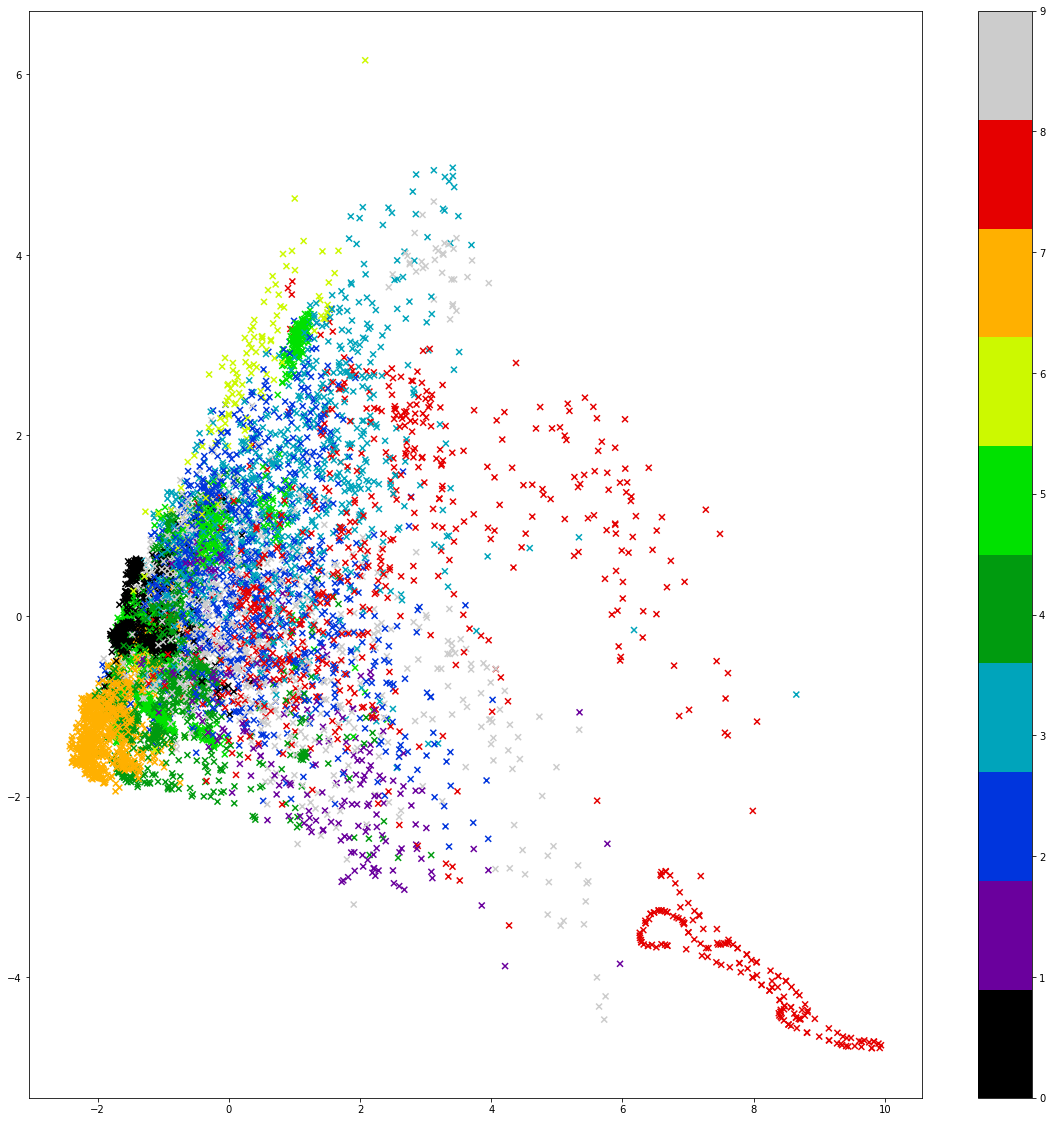

In [11]:
## 2D visualisation of features
plt.figure(figsize=(20, 20))
cmap = plt.get_cmap('spectral', 10)
plt.scatter(vis_pca[:, 0], vis_pca[:, 1], c=Y_train[0:8000], marker='x', cmap=cmap, alpha=100)
plt.colorbar()
plt.show()